In [9]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('titanic',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")

Local environment
Added the following directory to the PYTHONPATH: /home/jdowling/Projects/mlfs-book


In [10]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
import os
import hopsworks
import pandas as pd
from mlfs import config
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [11]:
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

project = hopsworks.login()
fs = project.get_feature_store()

2025-01-08 13:50:08,370 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-08 13:50:08,375 INFO: Initializing external client
2025-01-08 13:50:08,376 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 13:50:09,515 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/17565


In [12]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view

from hopsworks.hsfs.builtin_transformations import label_encoder

titanic_fg = fs.get_feature_group(name="titanic", version=1)
selected_features = titanic_fg.select_features()

feature_view = fs.get_or_create_feature_view(name="titanic",
                                             version=1,
                                             description="Read from Titanic Passengers Dataset",
                                             labels=["survived"],
                                             transformation_functions = [
                                                 label_encoder("sex" ),
                                                 label_encoder("embarked")
                                             ],
                                             query=selected_features)

2025-01-08 13:50:11,257 INFO: Using ['sex', 'age', 'pclass', 'fare', 'parch', 'sibsp', 'embarked', 'survived'] as features for the query.To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/17565/fs/17485/fv/titanic/version/1


In [14]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

X_train

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 
2025-01-08 13:52:37,297 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-01-08 13:52:38,961 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-01-08 13:52:38,985 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-01-08 13:52:39,511 WARNING: VersionWarning: Incremented version to `2`.



,age,pclass,fare,parch,sibsp,label_encoder_embarked_,label_encoder_sex_
0,42.000000,2,13.0000,0,0,2,0
1,20.000000,3,8.6625,0,0,2,1
2,29.699118,3,8.6625,0,0,2,1
3,47.000000,2,15.0000,0,0,2,1
4,35.000000,3,7.8958,0,0,0,1
...,...,...,...,...,...,...,...
884,45.000000,2,13.5000,0,0,2,0
886,19.000000,2,10.5000,0,0,2,1
887,61.000000,1,33.5000,0,0,2,1
888,2.000000,2,26.0000,1,1,2,0


In [15]:
# Train our model with XGBoost Classifier
model = xgb.XGBClassifier()
model.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)
y_pred

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1])

In [17]:
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)
metrics

{'0': {'precision': 0.839622641509434,
  'recall': 0.8165137614678899,
  'f1-score': 0.827906976744186,
  'support': 109.0},
 '1': {'precision': 0.726027397260274,
  'recall': 0.7571428571428571,
  'f1-score': 0.7412587412587412,
  'support': 70.0},
 'accuracy': 0.7932960893854749,
 'macro avg': {'precision': 0.782825019384854,
  'recall': 0.7868283093053735,
  'f1-score': 0.7845828590014636,
  'support': 179.0},
 'weighted avg': {'precision': 0.7951999202946787,
  'recall': 0.7932960893854749,
  'f1-score': 0.7940221919174758,
  'support': 179.0}}

2025-01-08 13:52:50,473 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

2025-01-08 13:52:50,543 WARNING: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown



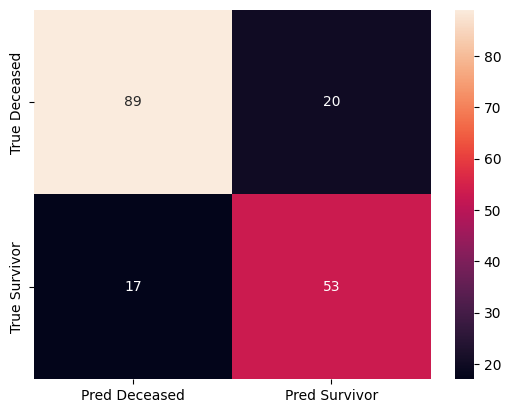

In [18]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Deceased', 'True Survivor'],
                     ['Pred Deceased', 'Pred Survivor'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

fig.show()

In [19]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="titanic_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if os.path.isdir(images_dir) == False:
    os.mkdir(images_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
# Saving the XGBoost regressor object as a json file in the model directory
model.save_model(model_dir + "/titanic_model.json")
fig.savefig(images_dir + "/confusion_matrix.png")    

# Create an entry in the model registry that includes the model's name, desc, metrics
titanic_model = mr.python.create_model(
    name="titanic", 
    metrics={"accuracy" : metrics['accuracy'], 
             'f1 score' : metrics['weighted avg']['f1-score']},
    feature_view=feature_view,
    description="Titanic Survivor Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
titanic_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/249092 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/17237 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/17565/models/titanic/1


Model(name: 'titanic', version: 1)